# Lifetime fit

In [1]:
import sys, os
from collections import defaultdict
import yaml
import numpy as np
from array import array

import h5py
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
from itertools import cycle
from collections import defaultdict
import matplotlib.dates as mdates
from datetime import datetime
import time

import plotly.graph_objects as go
import plotly.express as px

from ROOT import TCanvas, TGraph, TF1, TProfile, TFile, TTree, TLegend, TGraphErrors, gROOT, gStyle, TH2D

from root_numpy import array2root, array2hist, fill_hist

from h5flow.data import dereference

Welcome to JupyROOT 6.22/09


In [2]:
gStyle.SetTitleFontSize(0.05)
gStyle.SetLabelSize(0.05,"xyz")
gStyle.SetTitleSize(0.05,"xyz")
gStyle.SetPadLeftMargin(0.16)
gStyle.SetPadRightMargin(0.16)
gStyle.SetPadBottomMargin(0.12)
gStyle.SetOptStat(0)

In [3]:
## size of the detector in [mm]
#### set boundary at the edge of the LArPix, not the inner boundary of the fieldshell
#### set z boundary loosely at 0, 300 mm
pixel_pitch = 4.43399

z_min = 0
z_max = 300

vdrift = 1.5136504594138773 # mm/us for 0.5kV/cm

In [4]:
cathode_crosser = False

In [5]:
data = np.load(f"data/2022-08/track_purity_info_22-07_22-08_cathode_crossers_{cathode_crosser}.npz",allow_pickle=True)   

In [6]:
## sort out data by time
time_idx = data['data_time'].argsort()

data_time_st = data['data_time'][time_idx]
dQdx_st = data['dQdx'][time_idx]
tdrift_st = data['tdrift'][time_idx]

In [7]:
## group data within a period

period = 7200 #s -> 2hr

t_init = min(data_time_st)

data_time_merged = []
data_time_size_merged = []
dQdx_merged = []
tdrift_merged = []

data_time_period = []
dQdx_period = np.array([])
tdrift_period = np.array([])

for i_file in range(len(data_time_st)):
    if abs(data_time_st[i_file] - t_init) < 7200: # 2hr
        data_time_period.append(data_time_st[i_file])
        dQdx_period = np.append(dQdx_period, dQdx_st[i_file])
        tdrift_period = np.append(tdrift_period,tdrift_st[i_file])

    else:
        data_time_merged.append(0.5*(min(data_time_period) + max(data_time_period)))
        data_time_size_merged.append(max(data_time_period) - min(data_time_period))
        dQdx_merged.append(dQdx_period)
        tdrift_merged.append(tdrift_period)
          
        data_time_period = []
        dQdx_period = np.array([])
        tdrift_period = np.array([])
        t_init = data_time_st[i_file]
        
        data_time_period.append(data_time_st[i_file])
        dQdx_period = np.append(dQdx_period, dQdx_st[i_file])
        tdrift_period = np.append(tdrift_period,tdrift_st[i_file])
        
    if i_file == (len(data_time_st) - 1):
        data_time_merged.append(0.5*(min(data_time_period) + max(data_time_period)))
        data_time_size_merged.append(max(data_time_period) - min(data_time_period))
        dQdx_merged.append(dQdx_period)
        tdrift_merged.append(tdrift_period)
        print(data_time_merged[-1])

 
data_time_merged = array('f', data_time_merged)
data_time_size_merged = array('f', data_time_size_merged)
dQdx_merged = np.array(dQdx_merged)
tdrift_merged = np.array(tdrift_merged)


1659716533.75


/tmp/ipykernel_51555/3506683677.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dQdx_merged = np.array(dQdx_merged)
/tmp/ipykernel_51555/3506683677.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tdrift_merged = np.array(tdrift_merged)


/usr/local/lib/python3.8/dist-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h2(
/usr/local/lib/python3.8/dist-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addi

 FCN=30.2169 FROM MINOS     STATUS=SUCCESSFUL     42 CALLS         167 TOTAL
                     EDM=6.0501e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.84289e+00   1.25053e-01   1.43646e-03  -1.83642e-04
   2  p1           2.10481e+02   2.57782e+01   2.57782e+01  -1.93010e-04
 FCN=32.3508 FROM MINOS     STATUS=SUCCESSFUL     42 CALLS         176 TOTAL
                     EDM=5.05839e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.46993e+00   1.05977e-01   1.85097e-03  -4.73921e-04
   2  p1           3.00445e+02   4.44346e+01   4.44346e+01  -8.61054e-06
 FCN=26.7224 FROM MINOS     STATUS=SUCCESSFUL     42 CALLS         166 TOTAL
                     EDM=1.531

Info in <TCanvas::Print>: pdf file plots/2022-08/Purity/lifetime_binned_2022-07-30 08:40:32_2.10e+02us_fit_halfmax_t_cathode_crossers_False.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: th2d (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/2022-08/Purity/lifetime_binned_2022-07-30 10:44:16_3.00e+02us_fit_halfmax_t_cathode_crossers_False.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: th2d (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/2022-08/Purity/lifetime_binned_2022-07-30 12:48:00_2.19e+02us_fit_halfmax_t_cathode_crossers_False.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: th2d (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots/2022-08/Purity/lifetime

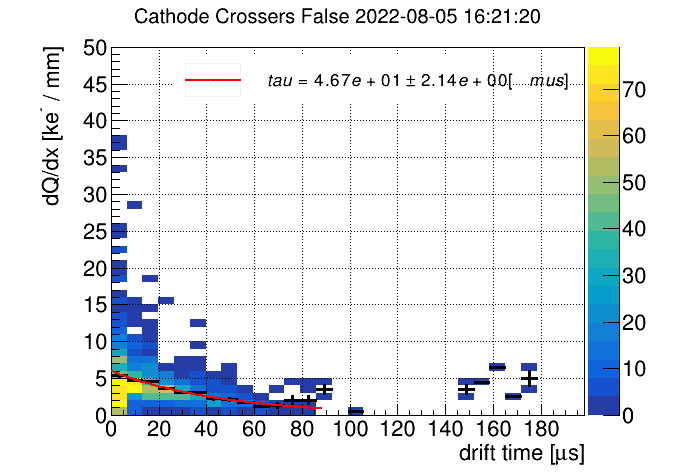

In [8]:
lifetime = []
lifetime_err = []
for i_fit in range(len(data_time_merged)):

    data2D = np.stack((tdrift_merged[i_fit], dQdx_merged[i_fit]), axis=-1)

    th2d = TH2D('th2d', '', 30, 0, z_max/vdrift, 50, 0, 50)
    fill_hist(th2d, data2D)

    tprof = th2d.ProfileX()

    c = TCanvas( 'c', '', 200, 10, 700, 500 )
    c.SetGrid()
    c.cd()

    th2d.SetTitle( f'Cathode Crossers {cathode_crosser} {datetime.utcfromtimestamp(data_time_merged[i_fit])}' )
#     th2d.SetTitle( f'{datetime.utcfromtimestamp(data_time_merged[i_fit]).strftime('%Y-%m-%d %H:%M:%S')}; Cathode Crossers {cathode_crosser}' )
    th2d.GetXaxis().SetTitle( "drift time [#mus]" )
    th2d.GetYaxis().SetTitle( "dQ/dx [ke^{-} / mm]" )
    th2d.Draw("colz")

    tprof.SetLineColor(1)
    tprof.SetLineWidth(3)
    tprof.Draw("SAME")

    p_init = 100

    func = TF1("func", "[0]*exp(-x/[1])", min(tdrift_merged[i_fit]), 0.5 * max(tdrift_merged[i_fit]), 2)
    func.SetParameters(5, p_init)

    tprof.Fit(func, "RME")

    p = func.GetParameters()    
    perr = func.GetParErrors()

    lg = TLegend(0.25,0.78,0.7,0.88)
    lg.SetTextSize(0.04)
    lg.SetLineWidth(0)

    par_tau = "{:.2e}".format(p[1])
    par_err = "{:.2e}".format(perr[1])
    
    lifetime.append(p[1])
    lifetime_err.append(perr[1])

    lg.AddEntry(func, f"#tau = {par_tau} \pm {par_err} [#mus]")
    lg.Draw("SAME")

    c.Update()
    c.Draw()
    c.SaveAs(f"plots/2022-08/Purity/lifetime_binned_{datetime.utcfromtimestamp(data_time_merged[i_fit]).strftime('%Y-%m-%d %H:%M:%S')}_{par_tau}us_fit_halfmax_t_cathode_crossers_{cathode_crosser}.pdf")
#     c.SaveAs(f"plots/2022-08/Purity/lifetime_binned_{datetime.utcfromtimestamp(data_time_merged[i_fit]).strftime('%Y-%m-%d %H:%M:%S')}_{par_tau}us_cathode_crossers_{cathode_crosser}.pdf")

lifetime = array('f', lifetime)
lifetime_err = array('f', lifetime_err)

Info in <TCanvas::Print>: pdf file plots/2022-08/Purity/lifetime_summary_fit_halfmax_t_cathode_crossers_False.pdf has been created


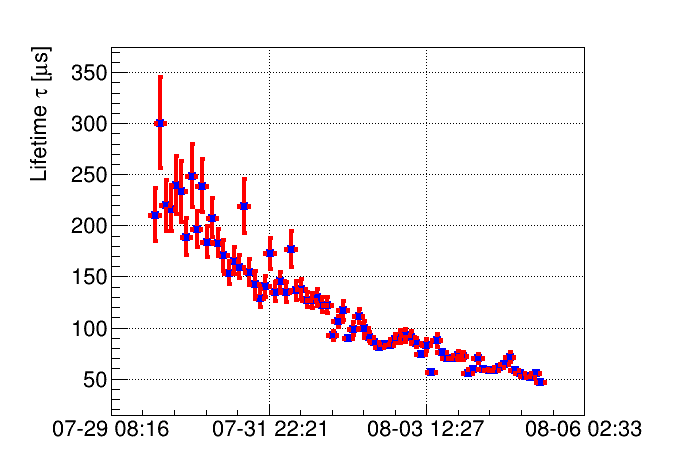

In [9]:
c1 = TCanvas( 'c1', '', 200, 10, 700, 500 )
c1.SetGrid()

# gr = TGraphErrors( len(data_time_merged), data_time_merged, lifetime, data_time_size_merged, life_time_err )
gr = TGraphErrors( len(data_time_merged), data_time_merged, lifetime, data_time_size_merged, lifetime_err )
gr.SetLineColor( 2 )
gr.SetLineWidth( 4 )
gr.SetMarkerColor( 4 )
gr.SetMarkerStyle( 21 )
gr.GetXaxis().SetTimeDisplay(1)
# gr.LabelsOption(“h”)
# gr.GetXaxis().SetTimeFormat("%Y-%m-%d %H:%M")
gr.GetXaxis().SetTimeFormat("%m-%d %H:%M")
gr.GetXaxis().SetNdivisions(-503)

gr.SetTitle( '' )
# gr.GetXaxis().SetTitle( 'X title' )
gr.GetYaxis().SetTitle( 'Lifetime #tau [#mus]' )
gr.Draw( 'AP' )

c1.Update()
c1.Draw()
c1.SaveAs(f"plots/2022-08/Purity/lifetime_summary_fit_halfmax_t_cathode_crossers_{cathode_crosser}.pdf")
# c1.SaveAs(f"plots/2022-08/Purity/lifetime_summary_cathode_crossers_{cathode_crosser}.pdf")
